# Rare Disease Decision Paths (Feasibility Matrix, Three Paths)

**Note:** All data in this notebook is synthetic and used solely to demonstrate decision analysis and portfolio optimization methodology.

### Data note

**All diseases, paths, probabilities, costs, timelines, and cashflows in this notebook are illustrative and fictional.**

They are used solely to demonstrate decision-analysis concepts and methods. They do not represent real diseases, programs, or investment recommendations.

### Development Paths — Visual Interpretation (Horizontal)

| Path | Core idea | Early cost & time | Late-stage risk | Peak upside | What you see in charts |
|---|---|---|---|---|---|
| **Biomarker-First** | Validate signal before scaling | ↑ cost, ↑ time | ↓ | ↓ | Later launch; smaller NPV bars; rNPV can be strong; distributions often tighter |
| **Straight** | Move fast with confidence | ↓ cost, ↓ time | ↑ | ↑ | Earlier launch; tall NPV bars; rNPV often reduced; distributions wider with heavier downside tails |
| **Partner** | Share cost and execution | ↓↓ internal cost | ↓ | ↓ | Lower NPV/rNPV; distributions often narrower; downside may be limited |

### How to read the arrows and terms

**All arrows (↑ ↓) are relative comparisons across paths for the *same disease*.** They do **not** compare diseases.

- **↑** = higher / more than the other paths for this disease
- **↓** = lower / less than the other paths for this disease
- **Late-stage risk** = higher/lower chance of failing in later, high-cost stages
- **Peak upside** = how large value could be *if successful* (the maximum potential, not the likelihood)

**Visual mapping:** NPV bars ≈ upside if successful; rNPV bars ≈ expected value after risk; distributions show uncertainty and downside tails.

### Setup

This notebook compares three development paths (paths) across multiple diseases.

A feasibility matrix is applied so that **not every disease is evaluated against every path**. Only feasible disease–path combinations are included in calculations and visuals.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
rng = np.random.default_rng(7)

### Feasibility matrix

A feasibility matrix defines which paths are considered viable for each disease.

The matrix used here:

| Disease  | Biomarker | Straight | Partner |
|----------|----------:|---------:|--------:|
| RD-Alpha | ✅        | ❌       | ✅      |
| RD-Beta  | ❌        | ✅       | ❌      |
| RD-Gamma | ✅        | ✅       | ❌      |

In the code, infeasible combinations are excluded from the dataset.

In [2]:
diseases = ['RD-Alpha','RD-Beta','RD-Gamma']
paths = ['Biomarker_First','Straight_Path','Partner_Path']
path_label_map = {
    'Biomarker_First': 'Biomarker-First',
    'Straight_Path': 'Straight',
    'Partner_Path': 'Partner'
}

feasible = {
    'RD-Alpha': {'Biomarker_First': True,  'Straight_Path': False, 'Partner_Path': True},
    'RD-Beta':  {'Biomarker_First': False, 'Straight_Path': True,  'Partner_Path': False},
    'RD-Gamma': {'Biomarker_First': True,  'Straight_Path': True,  'Partner_Path': False},
}

feas_df = pd.DataFrame([
    ['RD-Alpha', True,  False, True],
    ['RD-Beta',  False, True,  False],
    ['RD-Gamma', True,  True,  False],
], columns=['Disease','Biomarker_First','Straight_Path','Partner_Path'])
feas_df

,Disease,Biomarker_First,Straight_Path,Partner_Path
0,RD-Alpha,True,False,True
1,RD-Beta,False,True,False
2,RD-Gamma,True,True,False


### Biomarker-First Path

### What this path represents

The **Biomarker-First path** is a development strategy that prioritizes identifying or validating a biological marker before committing to later-stage development. A biomarker is a measurable signal that indicates whether the underlying disease mechanism is being engaged or whether a patient subgroup is more likely to benefit.

### Why this path exists

Later development stages are costly and difficult to reverse. This path accepts additional time and cost early in order to reduce uncertainty before advancing. The intent is to lower the risk of late-stage failure, which is typically the most expensive outcome.

### Typical trade-offs

- Higher upfront cost and longer early timelines
- Increased confidence in later milestones
- Potentially narrower patient population and lower peak upside

### How this is reflected in the model

In this notebook, the Biomarker-First path is represented by:
- milestone probabilities that improve in later phases,
- a delayed launch timeline relative to faster paths,
- and commercial cashflows that reflect a more targeted population.

These assumptions encode the trade-off between early investment and reduced downstream risk.

### Feasibility considerations

A Biomarker-First path is only feasible when a measurable and actionable biomarker exists. For diseases where no such biomarker is available, this path is excluded in the feasibility matrix.

### Summary

The Biomarker-First path delays broad advancement in exchange for improved certainty, often resulting in a stronger risk-adjusted profile even when time to value is longer.

### Straight Path

### What this path represents

The **Straight Path** advances directly through the standard development sequence without adding extra
validation work beyond what is required. It prioritizes speed and simplicity.

### Why this path exists

This path is used when baseline confidence is high enough to justify moving quickly. The main benefit is
earlier potential value because benefits arrive sooner and are discounted less.

### Typical trade-offs

- Faster timelines and earlier launch
- Lower upfront work than validation-heavy approaches
- Greater exposure to late-stage failure if early assumptions are wrong

### How this is reflected in the model

In this notebook, the Straight Path is encoded with:
- an earlier launch year,
- milestone probabilities that are not boosted by additional validation,
- full commercial upside if successful.

### Feasibility considerations

This path is feasible when patient identification and biology are sufficiently clear. If uncertainty is high,
this path may be marked infeasible in the feasibility matrix.

### Partner Path

### What this path represents

The **Partner Path** shares development with another organization. Costs and execution risk are reduced
internally, but economic upside is shared.

### Why this path exists

This path is used to reduce required internal investment, access partner capabilities, or manage risk when
resources are constrained.

### Typical trade-offs

- Lower internal costs and reduced financial exposure
- Shared execution and development risk
- Reduced commercial upside due to shared economics and/or profit split

### How this is reflected in the model

In this notebook, the Partner Path is encoded with:
- lower development costs,
- reduced commercial cashflows (shared economics),
- and (optionally) slightly different milestone probabilities.

### Feasibility considerations

This path is feasible only when a suitable partner and workable terms exist. If partnership is not realistic
for a disease, this path is marked infeasible in the feasibility matrix.

### Step 1: Build the dataset (feasible combinations only)

Each row represents one event (milestone or cashflow) for a feasible disease–path pair.
Infeasible disease–path combinations are not created.

In [17]:
rows = []
base_benefits = {'RD-Alpha':900,'RD-Beta':650,'RD-Gamma':1200}

for d in diseases:
    for p in paths:
        if not feasible[d][p]:
            continue

        if p == 'Biomarker_First':
            probs = [0.70, 0.75, 0.45, 0.65, 0.90]
            costs = [-35, -60, -120, -180, 0]
            launch_year = 8
            benefit_mult = 0.95
        elif p == 'Straight_Path':
            probs = [0.65, 0.70, 0.38, 0.60, 0.88]
            costs = [-30, -55, -110, -170, 0]
            launch_year = 7
            benefit_mult = 1.00
        else:
            probs = [0.62, 0.68, 0.36, 0.58, 0.86]
            costs = [-20, -40, -85, -140, 0]
            launch_year = 7
            benefit_mult = 0.75

        steps = ['Preclinical','Phase1','Phase2','Phase3','Approval']
        cost_years = [0,1,3,5,6]
        for step, year, cf, ps in zip(steps, cost_years, costs, probs):
            rows.append([d,p,step,year,cf,ps,path_label_map[p]])

        benefits = [0.25,0.40,0.50,0.45,0.30]
        for k,b in enumerate(benefits):
            rows.append([d,p,f'CF_{k+1}',launch_year+k,base_benefits[d]*benefit_mult*b,1.0,path_label_map[p]])

df = pd.DataFrame(rows, columns=['disease','path','step','year','cashflow','p_step','path_label'])
df.head()

,disease,path,step,year,cashflow,p_step,path_label
0,RD-Alpha,Biomarker_First,Preclinical,0,-35.00,0.70,Biomarker-First
1,RD-Alpha,Biomarker_First,Phase1,1,-60.00,0.75,Biomarker-First
2,RD-Alpha,Biomarker_First,Phase2,3,-120.00,0.45,Biomarker-First
3,RD-Alpha,Biomarker_First,Phase3,5,-180.00,0.65,Biomarker-First
4,RD-Alpha,Biomarker_First,Approval,6,0.00,0.90,Biomarker-First


### Core calculations

Probability of success is the product of milestone probabilities. NPV discounts cashflows. rNPV multiplies NPV by PoS.

In [18]:
DISCOUNT_RATE = 0.10

def pos_from_steps(step_probs):
    return float(np.prod(step_probs))

def npv_from_cashflows(cashflows_by_year, r):
    return sum(cf / ((1+r)**y) for y, cf in cashflows_by_year.items())

### Summary metrics by disease and feasible path

In [5]:
rows = []
for (disease, path), sub in df.groupby(['disease','path']):
    cashflows = sub.groupby('year')['cashflow'].sum().to_dict()
    milestone = sub[(~sub['step'].str.startswith('CF_'))]
    pos = pos_from_steps(milestone['p_step'].values)
    npv = npv_from_cashflows(cashflows, DISCOUNT_RATE)
    rnpv = npv * pos
    rows.append([disease,path,sub['path_label'].iloc[0],pos,npv,rnpv])

summary = pd.DataFrame(rows, columns=['Disease','Path_Key','Path','PoS','NPV','rNPV'])
summary.sort_values(['Disease','rNPV'], ascending=[True, False]).reset_index(drop=True)

,Disease,Path_Key,Path,PoS,NPV,rNPV
0,RD-Alpha,Biomarker_First,Biomarker-First,0.14,334.69,46.26
1,RD-Alpha,Partner_Path,Partner,0.08,336.61,25.48
2,RD-Beta,Straight_Path,Straight,0.09,255.43,23.32
3,RD-Gamma,Biomarker_First,Biomarker-First,0.14,543.41,75.10
4,RD-Gamma,Straight_Path,Straight,0.09,698.50,63.77


In [6]:
# Enforce strategy display names (ensures no color-based labels leak into outputs)
strategy_label_map = {
    'Biomarker_First': 'Biomarker-First',
    'Straight_Path': 'Straight',
    'Partner_Path': 'Partner',
}
# If summary/options tables exist, standardize displayed Path column
if 'summary' in globals():
    if 'Path_Key' in summary.columns and 'Path' in summary.columns:
        summary['Path'] = summary['Path_Key'].map(strategy_label_map).fillna(summary['Path'])
if 'options' in globals():
    if 'Path_Key' in options.columns and 'Path' in options.columns:
        options['Path'] = options['Path_Key'].map(strategy_label_map).fillna(options['Path'])


### Interpreting the scores and outcomes

This notebook produces several score columns and visuals. Each one answers a different question.

### PoS (Probability of Success)
- **What it is:** the product of milestone-step probabilities.
- **What it means:** the chance the path reaches the point where post-launch cashflows occur.

### NPV (Net Present Value)
- **What it is:** the discounted sum of all cashflows, treating the cashflows as if they occur.
- **What it means:** value *assuming success* (uncertainty not applied).

### rNPV (Risk-adjusted NPV)
- **What it is:** **rNPV = NPV × PoS**.
- **What it means:** expected present value after accounting for both timing and uncertainty.

### Best path per disease
- The notebook selects, for each disease, the **feasible path with the highest rNPV**.
- If a disease has only one feasible path, that path is selected by definition.

### How to read the bar charts
- **NPV by Path:** compares value assuming success.
- **rNPV by Path:** compares expected value after uncertainty.

### How to read the distribution (simulation) plots
- The **center** (median) shows typical outcomes.
- The **width** shows uncertainty.
- The **left tail** shows downside risk.
- A path can have the best **average** but still have an unattractive profile if downside risk is large.

### Best feasible path per disease

For each disease, select the feasible path with the highest rNPV.

In [7]:
best = (summary.sort_values(['Disease','rNPV'], ascending=[True, False])
        .groupby('Disease', as_index=False)
        .head(1)
        .reset_index(drop=True))
best

,Disease,Path_Key,Path,PoS,NPV,rNPV
0,RD-Alpha,Biomarker_First,Biomarker-First,0.14,334.69,46.26
1,RD-Beta,Straight_Path,Straight,0.09,255.43,23.32
2,RD-Gamma,Biomarker_First,Biomarker-First,0.14,543.41,75.10


### Visual comparison by disease

Bar charts show NPV and rNPV by path for each disease (feasible paths only).

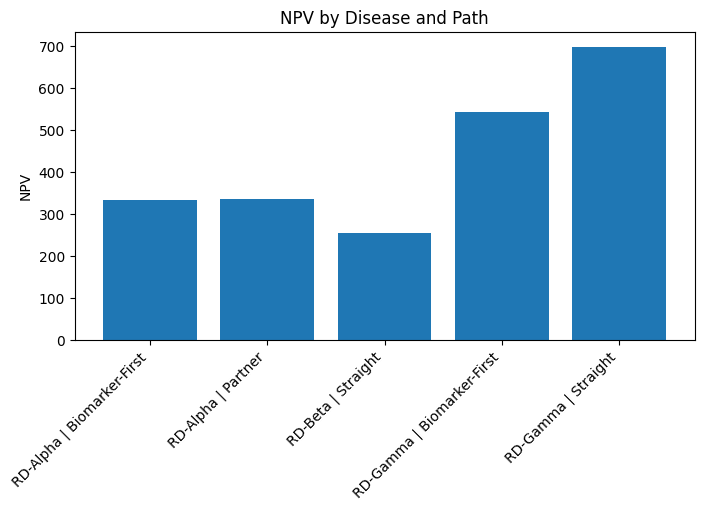

In [19]:
plt.figure(figsize=(8,4))
plt.bar(summary['Disease'] + " | " + summary['Path'], summary['NPV'])
plt.ylabel('NPV')
plt.title('NPV by Disease and Path')
plt.xticks(rotation=45, ha='right')
plt.show()


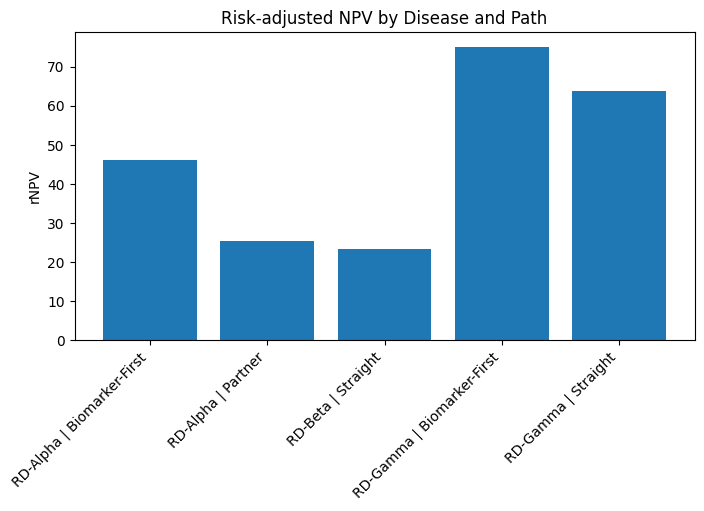

In [20]:
plt.figure(figsize=(8,4))
plt.bar(summary['Disease'] + " | " + summary['Path'], summary['rNPV'])
plt.ylabel('rNPV')
plt.title('Risk-adjusted NPV by Disease and Path')
plt.xticks(rotation=45, ha='right')
plt.show()


### Uncertainty simulation

Simulates uncertainty in milestone probabilities and commercial scale to generate rNPV distributions.

In [9]:
def beta_from_mean_strength(mean, strength=40):
    a = mean*strength
    b = (1-mean)*strength
    return a,b

def simulate_path(sub, n=4000):
    milestone = sub[(~sub['step'].str.startswith('CF_'))]
    commercial = sub[sub['step'].str.startswith('CF_')]
    fixed = sub[~sub.index.isin(commercial.index)]

    fixed_cf = fixed.groupby('year')['cashflow'].sum().to_dict()
    comm_cf = commercial.groupby('year')['cashflow'].sum().to_dict()

    out = []
    for _ in range(n):
        ps = []
        for p in milestone['p_step']:
            a,b = beta_from_mean_strength(p)
            ps.append(rng.beta(a,b))
        pos = np.prod(ps)
        mult = np.exp(rng.normal(0,0.25))
        cash = dict(fixed_cf)
        for y,cf in comm_cf.items():
            cash[y] = cash.get(y,0) + cf*mult
        out.append(npv_from_cashflows(cash, DISCOUNT_RATE)*pos)
    return np.array(out)

### Distribution plots by disease

Each plot shows simulated rNPV distributions for feasible paths for one disease.

### How to interpret these distributions

- The **center** of a distribution reflects typical outcomes.
- The **width** reflects uncertainty.
- The **left tail** reflects downside risk.
- A path can have the highest **average** but still be less attractive if it has a large downside tail.
- A risk-adjusted preference balances expected value with downside risk (for example, higher median and less extreme downside).

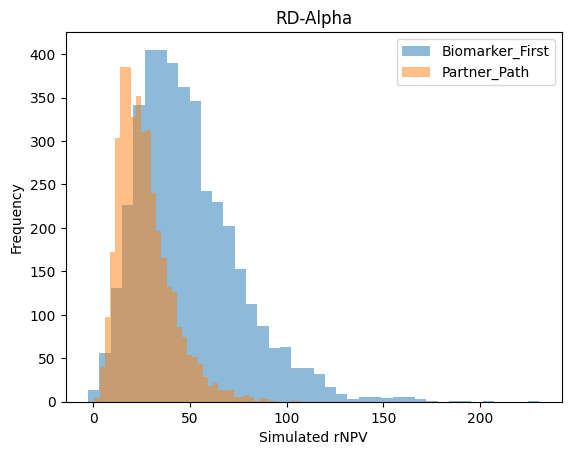

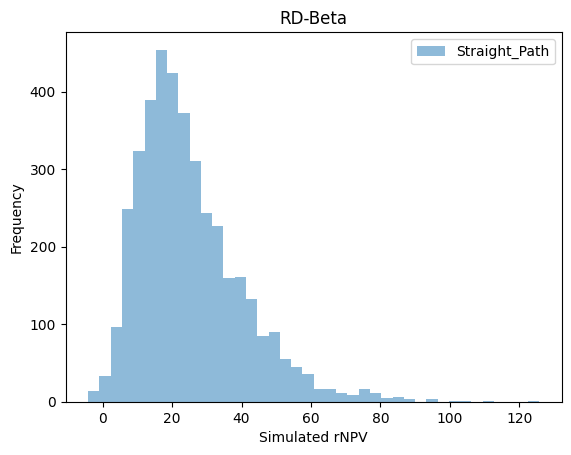

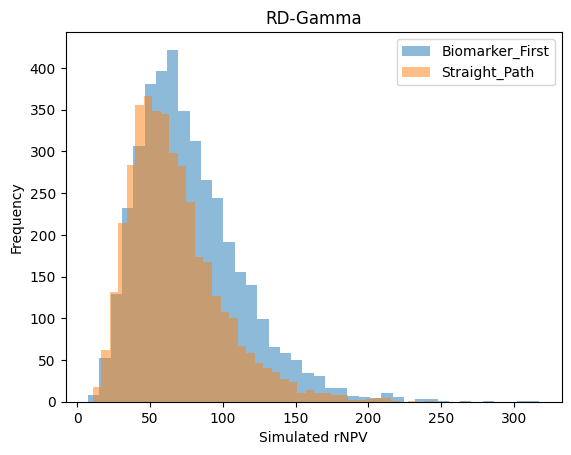

In [10]:
for disease in df['disease'].unique():
    sub_paths = df[df['disease']==disease]['path'].unique()
    plt.figure()
    for path in sub_paths:
        sims = simulate_path(df[(df['disease']==disease) & (df['path']==path)])
        plt.hist(sims, bins=40, alpha=0.5, label=path)
    plt.title(disease)
    plt.xlabel('Simulated rNPV')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Portfolio optimization under constraints

This section demonstrates a common planning-cycle question:

**Given feasible options, which set should be selected under resource constraints?**

Here the decision is to choose **at most one path per disease**. We maximize total **expected value (rNPV)**
subject to:
- a **budget cap** (present value of development costs), and optionally
- a **downside risk guardrail** using the simulation distribution (e.g., p10).

This keeps the same valuation logic already used above, but adds a selection step across multiple assets.

In [11]:
# Compute PV of costs (discounted negative cashflows only) for each disease-path option
def pv_costs(sub, r=DISCOUNT_RATE):
    cf_by_year = sub.groupby('year')['cashflow'].sum().to_dict()
    pv = 0.0
    for y, cf in cf_by_year.items():
        if cf < 0:
            pv += (-cf) / ((1+r)**y)  # positive cost
    return pv

# Build an option table: one row per feasible disease-path
option_rows = []
for (disease, path), sub in df.groupby(['disease','path']):
    # expected metrics (already in summary)
    row = summary[(summary['Disease']==disease) & (summary['Path_Key']==path)].iloc[0]
    # PV of costs
    cost_pv = pv_costs(sub)
    option_rows.append([
        disease,
        path,
        row.get('Path', path),
        float(row['PoS']),
        float(row['NPV']),
        float(row['rNPV']),
        cost_pv
    ])

options = pd.DataFrame(option_rows, columns=['Disease','Path_Key','Path','PoS','NPV','rNPV','PV_Cost'])
options.sort_values(['Disease','rNPV'], ascending=[True, False]).reset_index(drop=True)

,Disease,Path_Key,Path,PoS,NPV,rNPV,PV_Cost
0,RD-Alpha,Biomarker_First,Biomarker-First,0.14,334.69,46.26,291.47
1,RD-Alpha,Partner_Path,Partner,0.08,336.61,25.48,207.15
2,RD-Beta,Straight_Path,Straight,0.09,255.43,23.32,268.20
3,RD-Gamma,Biomarker_First,Biomarker-First,0.14,543.41,75.10,291.47
4,RD-Gamma,Straight_Path,Straight,0.09,698.50,63.77,268.20


In [12]:
# Add downside risk metrics from simulation (p10 = 10th percentile of simulated rNPV)
downside_rows = []
for i, opt in options.iterrows():
    sub = df[(df['disease']==opt['Disease']) & (df['path']==opt['Path_Key'])]
    sims = simulate_path(sub, n=4000)
    p10 = float(np.percentile(sims, 10))
    p50 = float(np.percentile(sims, 50))
    downside_rows.append((p10, p50))

options['rNPV_p10'] = [x[0] for x in downside_rows]
options['rNPV_p50'] = [x[1] for x in downside_rows]
options

,Disease,Path_Key,Path,PoS,NPV,rNPV,PV_Cost,rNPV_p10,rNPV_p50
0,RD-Alpha,Biomarker_First,Biomarker-First,0.14,334.69,46.26,291.47,19.41,43.85
1,RD-Alpha,Partner_Path,Partner,0.08,336.61,25.48,207.15,11.53,23.98
2,RD-Beta,Straight_Path,Straight,0.09,255.43,23.32,268.20,8.88,22.05
3,RD-Gamma,Biomarker_First,Biomarker-First,0.14,543.41,75.10,291.47,38.23,72.84
4,RD-Gamma,Straight_Path,Straight,0.09,698.50,63.77,268.20,32.90,60.89


### Optimization logic

Because the example is small, we can brute-force all combinations:
- pick one option per disease (or skip a disease if desired),
- compute total rNPV and total PV costs,
- keep combinations that meet constraints,
- choose the best feasible combination.

This is equivalent to an integer programming setup, but requires no extra packages.

What this code is doing:

It tries every allowed combination of projects, checks if each combo stays within budget and downside limits, and keeps the one with the highest total rNPV.

In [13]:
from itertools import product

# Build candidate lists per disease (allow 'skip' option)
disease_list = sorted(options['Disease'].unique())
candidates = {}
for d in disease_list:
    cand = options[options['Disease']==d].copy()
    # add a 'skip' option (select nothing for this disease)
    skip = pd.DataFrame([{
        'Disease': d,
        'Path_Key': 'SKIP',
        'Path': 'Skip',
        'PoS': 0.0,
        'NPV': 0.0,
        'rNPV': 0.0,
        'PV_Cost': 0.0,
        'rNPV_p10': 0.0,
        'rNPV_p50': 0.0,
    }])
    candidates[d] = pd.concat([cand, skip], ignore_index=True)

# Constraint settings (edit these numbers)
BUDGET_CAP = 250  # PV cost budget (same units as cashflows)
MIN_PORTFOLIO_P10 = -50  # downside guardrail; total p10 must be above this (optional)

def portfolio_score(combo_rows):
    total_rnpv = sum(r['rNPV'] for r in combo_rows)
    total_cost = sum(r['PV_Cost'] for r in combo_rows)
    # simple additive downside proxy: sum of option p10s
    total_p10 = sum(r['rNPV_p10'] for r in combo_rows)
    return total_rnpv, total_cost, total_p10

best_combo = None
best_rnpv = -1e18

for picks in product(*[candidates[d].to_dict('records') for d in disease_list]):
    total_rnpv, total_cost, total_p10 = portfolio_score(picks)
    if total_cost <= BUDGET_CAP and total_p10 >= MIN_PORTFOLIO_P10:
        if total_rnpv > best_rnpv:
            best_rnpv = total_rnpv
            best_combo = (picks, total_rnpv, total_cost, total_p10)

best_combo[1:] if best_combo else 'No feasible solution under current constraints'

(25.483714404844832, 207.15437966855214, 11.527435430635325)

In [14]:
# Display the selected portfolio
if best_combo:
    picks, total_rnpv, total_cost, total_p10 = best_combo
    selected = pd.DataFrame(picks)[['Disease','Path','rNPV','PV_Cost','rNPV_p10']]
    selected = selected[selected['Path']!='Skip'].reset_index(drop=True)
    selected


In [15]:
# Portfolio summary
if best_combo:
    picks, total_rnpv, total_cost, total_p10 = best_combo
    print('Budget cap (PV):', BUDGET_CAP)
    print('Total PV cost:', round(total_cost, 2))
    print('Total rNPV:', round(total_rnpv, 2))
    print('Total downside proxy (sum p10):', round(total_p10, 2))

Budget cap (PV): 250
Total PV cost: 207.15
Total rNPV: 25.48
Total downside proxy (sum p10): 11.53


### Visual: selected portfolio vs all options

This chart compares the chosen options against the available option set.
X-axis: PV Cost, Y-axis: rNPV. Each point is one feasible disease-path option.

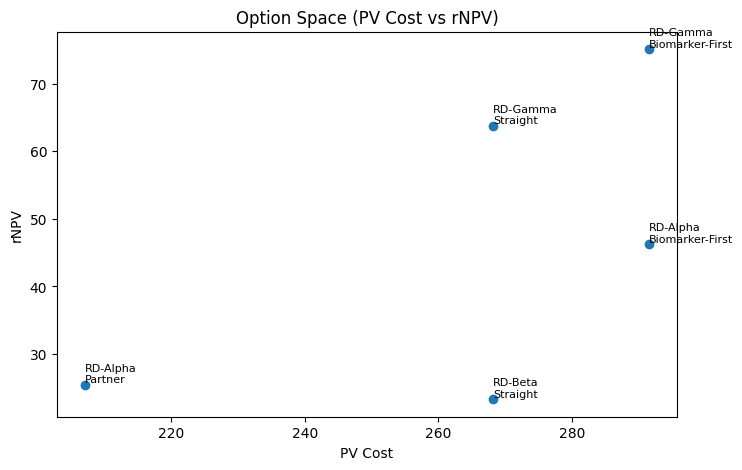

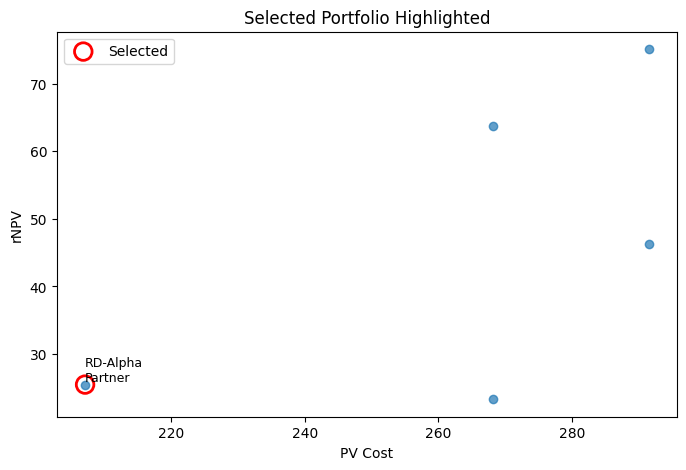

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Option space with labels (all options)
plt.figure(figsize=(8, 5))
plt.scatter(options['PV_Cost'], options['rNPV'])

for _, r in options.iterrows():
    plt.text(
        r['PV_Cost'],
        r['rNPV'],
        f"{r['Disease']}\n{r['Path']}",
        fontsize=8,
        ha='left',
        va='bottom'
    )

plt.xlabel('PV Cost')
plt.ylabel('rNPV')
plt.title('Option Space (PV Cost vs rNPV)')
plt.show()

# 2) Highlight selected portfolio on the same option space
if best_combo:
    picks, total_rnpv, total_cost, total_p10 = best_combo
    selected = pd.DataFrame(picks)
    selected = selected[selected['Path'] != 'Skip']

    plt.figure(figsize=(8, 5))

    # plot all options (base layer)
    plt.scatter(options['PV_Cost'], options['rNPV'], alpha=0.7)

    # highlight selected options (overlay) - red outline, hollow markers
    if not selected.empty:
        plt.scatter(
            selected['PV_Cost'],
            selected['rNPV'],
            s=160,
            facecolors='none',
            edgecolors='red',
            linewidths=2,
            label='Selected'
        )

        # optional: label ONLY selected options so it doesn't get messy
        for _, r in selected.iterrows():
            plt.text(
                r['PV_Cost'],
                r['rNPV'],
                f"{r['Disease']}\n{r['Path']}",
                fontsize=9,
                ha='left',
                va='bottom'
            )

    plt.xlabel('PV Cost')
    plt.ylabel('rNPV')
    plt.title('Selected Portfolio Highlighted')
    plt.legend()
    plt.show()
else:
    print("No feasible solution under current constraints.")


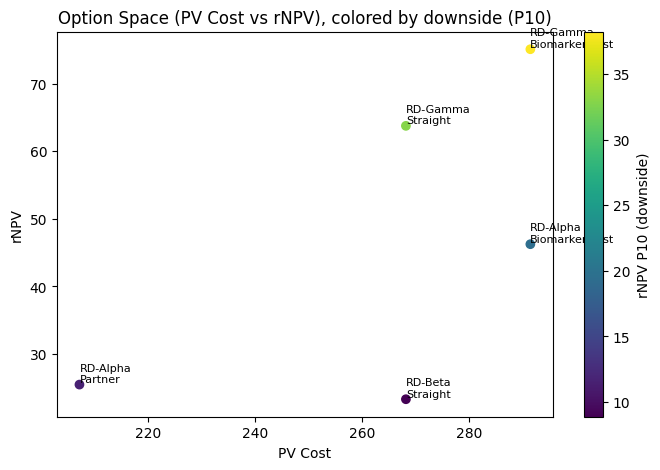

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# color = downside (P10)
sc = plt.scatter(
    options['PV_Cost'],
    options['rNPV'],
    c=options['rNPV_p10'],
)

# label each point
for _, r in options.iterrows():
    plt.text(r['PV_Cost'], r['rNPV'], f"{r['Disease']}\n{r['Path']}", fontsize=8,
             ha='left', va='bottom')

plt.xlabel('PV Cost')
plt.ylabel('rNPV')
plt.title('Option Space (PV Cost vs rNPV), colored by downside (P10)')
plt.colorbar(sc, label='rNPV P10 (downside)')
plt.show()
